## Profit Maximization of Airbnb Listings Using Occupancy Rate Regressor Model

## Team
Alice Galvao Vieira (alicegvieira)

Amelia Beaver (ac-beaver)

Matthew Gennaro (POC) (matthewgennaro)

Nikita Sharma (niksisharma)

Olivia O'Hanlon(oaohanlo)

**Link to data: https://drive.google.com/drive/folders/1eno42_rkIqzg-0HGAqxZ5gqVDv1pm8JB?usp=sharing**

## Introduction

Setting the right price for an Airbnb listing is a common challenge for hosts and investors. Many rely on guesswork or copy nearby listings without knowing how those prices really impact bookings. This creates uncertainty around profit potential and can lead to underpricing or missed opportunities, especially for those trying to scale their rental income or make informed investment decisions.

Our project focuses on solving this by predicting a listing’s occupancy rate, which we define as the percentage of days a property is booked in a year. We use a regression model trained on publicly available Airbnb data to estimate this rate based on features like price, property type, location, and amenities. Then, using the predicted occupancy, we calculate expected profit for different price points to find the one that maximizes annual revenue.

This approach gives stakeholders a data-backed way to set prices that match their goals. While our current model face some limitations, mainly due to limitations in how occupancy is estimated, this project represents a meaningful step toward automating pricing strategies and helping stakeholders make smarter financial decisions.

## Literature Review

This project addresses a real need: helping Airbnb hosts and investors set better prices using data. Previous research from Cornell University (https://pages.github.coecis.cornell.edu/info2950-s23/project-wondrous-raichu/report.html) explored predicting Airbnb prices based on listing features and also looked at variable interactions through EDA (https://pages.github.coecis.cornell.edu/info2950-s23/project-wondrous-raichu/eda.html). While their goal was price prediction, not occupancy, their work helped guide our feature selection and modeling choices.

We also found work on price optimization using machine learning in commercial settings (https://medium.com/academy-team/price-optimization-with-machine-learning-the-impact-of-data-science-on-commercial-strategies-a87b6dbe95e0). These studies show that predicting user behavior (like booking likelihood) is useful for setting prices that maximize profit.

Based on this, we chose a regression model to predict occupancy rate—a continuous value from 0 to 0.7. This lets us estimate profits across different prices and find the one that works best for each listing.

## Data and Methods

### Data

For this project, we used Airbnb listing data from Inside Airbnb (https://insideairbnb.com/get-the-data/), a public source that offers scraped datasets from Airbnb’s platform. It is widely used for research and analysis, and it provides good coverage of listing features, availability, and reviews. We worked with data from three major U.S. cities: Los Angeles (CA), Austin (TX), and New York City (NY).

A final combined dataset was created using 2 main datasets: Listings and Listings Reviews. The first one contains 98,246 rows and 79 columns, includes detailed info about the host, property, location, availability, amenities and booking informations. After performing some data exploration we filtered out listings that we deemed to be unusual listings. 
The reviews dataset contains 655,457 rows and 2 columns, each row logs a review made for a listing. We filtered this dataset to only include reviews made between January 1, 2024 and December 31, 2024. This create a consistent 1-year window for measuring occupancy. Our data contains a blend of numeric and categorical variables. Some of our categorical variables in particular contain a large amount of unique answer (particularly in the neighboorhood and amenities variables). After processing our categorical variables and removing other unnecessary variables, out final dataset ended up with 252 total features.

**Target Variable: Occupancy Rate**

Our target variable is occupancy_rate, which tells us how often a listing is booked in a year. Since actual booking data isn’t available, we followed the estimation approach outlined by Inside Airbnb (https://insideairbnb.com/data-assumptions/), which suggests using review activity as a proxy for bookings. We used the reviews_per_month column, an estimate of how many reviews a listing gets on average each month. We then applied the following formula:

$$
\text{occupancy\_rate} = \frac{\text{reviews\_per\_month} \times 5.5 \times 12}{366}
$$

The factor 5.5 reflects an assumption that roughly 1 in every 5.5 guests leaves a review. We multiply by 12 to scale to a full year, and divide by 366 since 2024 is a leap year. This gives us an estimated daily booking rate between 0 and 1 for each listing. While it’s not perfect, this method is widely used.

Finally, we decided to capped our occupancy rate to a range of (0, 0.7]. This left our dataset to contain 28,788 observations. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
listings = pd.read_csv("combined_listings_clean.csv")

### Analysis of Listings Price

Below we are looking at the effects of price on the occupancy rate using scatter plots. We will also look at the coordinate positioning of the Airbnb listing to see if there is some relation between price and/or occupancy rate. 

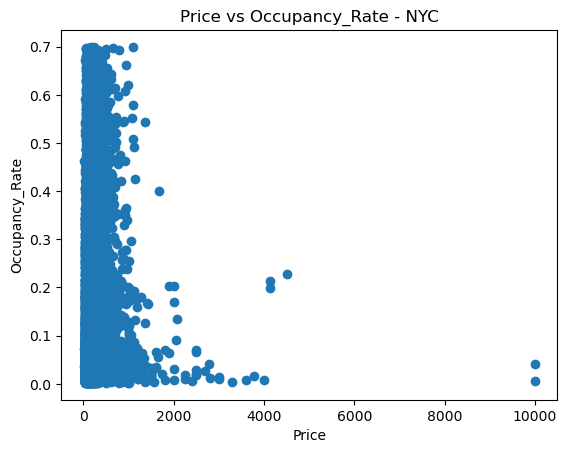

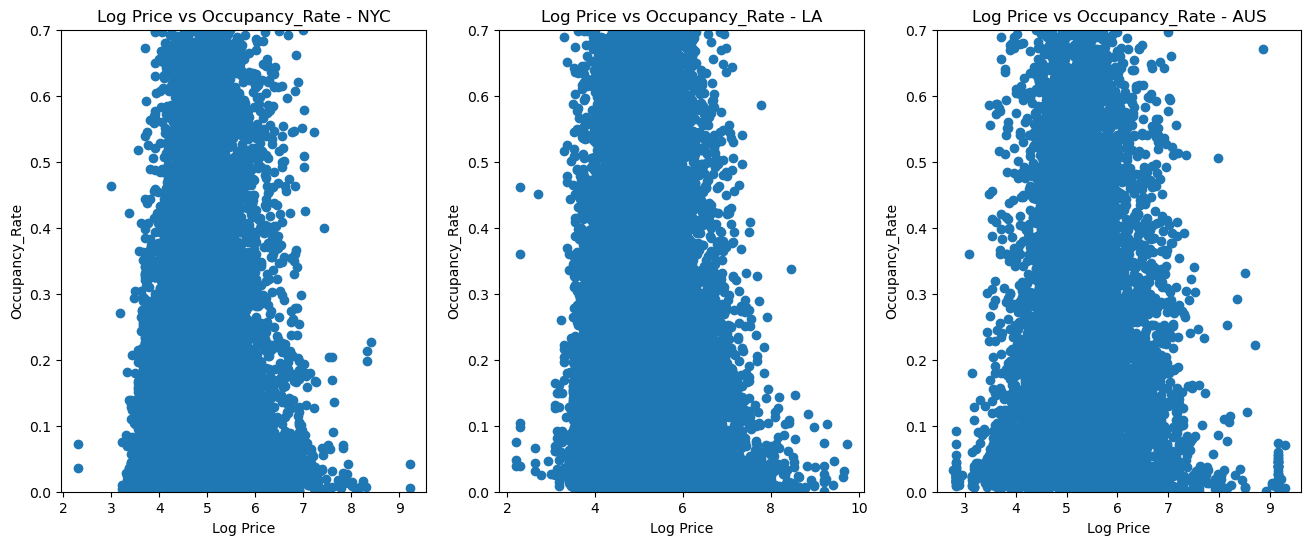

In [2]:
nyc = listings[listings['City'] == 'New York City']
aus = listings[listings['City'] == 'Austin']
la = listings[listings['City'] == 'Los Angeles']

plt.scatter(np.exp(nyc['log_price']), nyc['Occupancy_Rate'])
plt.xlabel('Price')
plt.ylabel('Occupancy_Rate')
plt.title('Price vs Occupancy_Rate - NYC')
plt.show()

# Found some extreme values, need to investigate or scale price:
#log(Price) x Occupancy_Rate
fig,axes = plt.subplots(1,3,figsize=(16,6))
axes[0].scatter(nyc['log_price'], nyc['Occupancy_Rate'])
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Occupancy_Rate')
axes[0].set_title('Log Price vs Occupancy_Rate - NYC')
axes[0].set_ylim(0, 0.7)

axes[1].scatter(la['log_price'], la['Occupancy_Rate'])
axes[1].set_xlabel('Log Price')
axes[1].set_ylabel('Occupancy_Rate')
axes[1].set_title('Log Price vs Occupancy_Rate - LA')
axes[1].set_ylim(0, 0.7)

axes[2].scatter(aus['log_price'], aus['Occupancy_Rate'])
axes[2].set_xlabel('Log Price')
axes[2].set_ylabel('Occupancy_Rate')
axes[2].set_title('Log Price vs Occupancy_Rate - AUS')
axes[2].set_ylim(0, 0.7)
plt.show()

The first plot shows Price as is, but with the outliers the graphs is poor. By taking the log of the price, we are able to visualize a better pattern in the plots below the initial. From the logged Prices vs Occupancy graphs, we can see a slight right skew in the distribution of the data. In the looking with the Occupancy Rate base off the fuzzy coordinates (Airbnb does not give the exact coordinates) of the listings location we can not see much of any trend on occupancy rate. When looking the coordinates with Logged Price we can see a some patterns of price bubbles in each city.

#### Price x Location
Analyzing the relationship between the AirBNB listing price and the Location

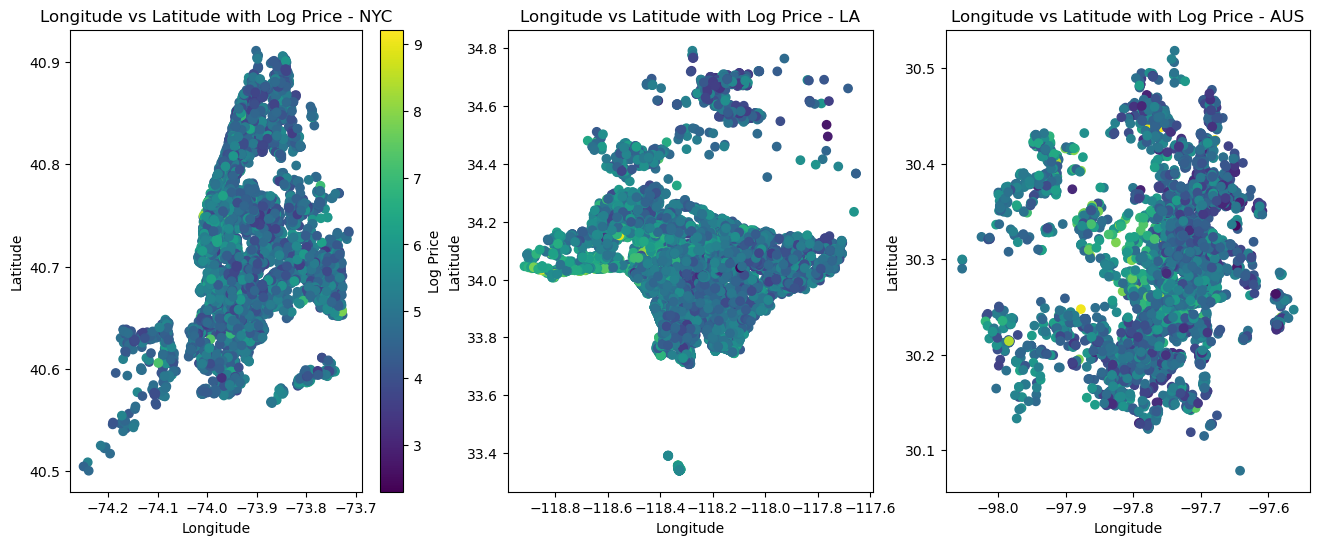

In [3]:
#latitude and longitude with np.log(Price)
fig,axes = plt.subplots(1,3,figsize=(16,6))
sc = axes[0].scatter(nyc['longitude'], nyc['latitude'], c=nyc['log_price'], cmap='viridis')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Longitude vs Latitude with Log Price - NYC')

axes[1].scatter(la['longitude'], la['latitude'], c=la['log_price'], cmap='viridis')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('Longitude vs Latitude with Log Price - LA')

axes[2].scatter(aus['longitude'], aus['latitude'], c=aus['log_price'], cmap='viridis')
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')
axes[2].set_title('Longitude vs Latitude with Log Price - AUS')
fig.colorbar(sc, ax=axes[0], label='Log Price')
plt.show()

- The graphs suggests there are certain “hotspots” where prices tend to be higher. For NYC, these are likely in Manhattan; for LA, near the coastline or other high-demand areas; and for Austin, near the city center or trendy neighborhoods.

- Listings farther from prime locations often have lower prices, which could indicate less demand or different property types.

### Analysis of Host information

#### Superhost and Response Time

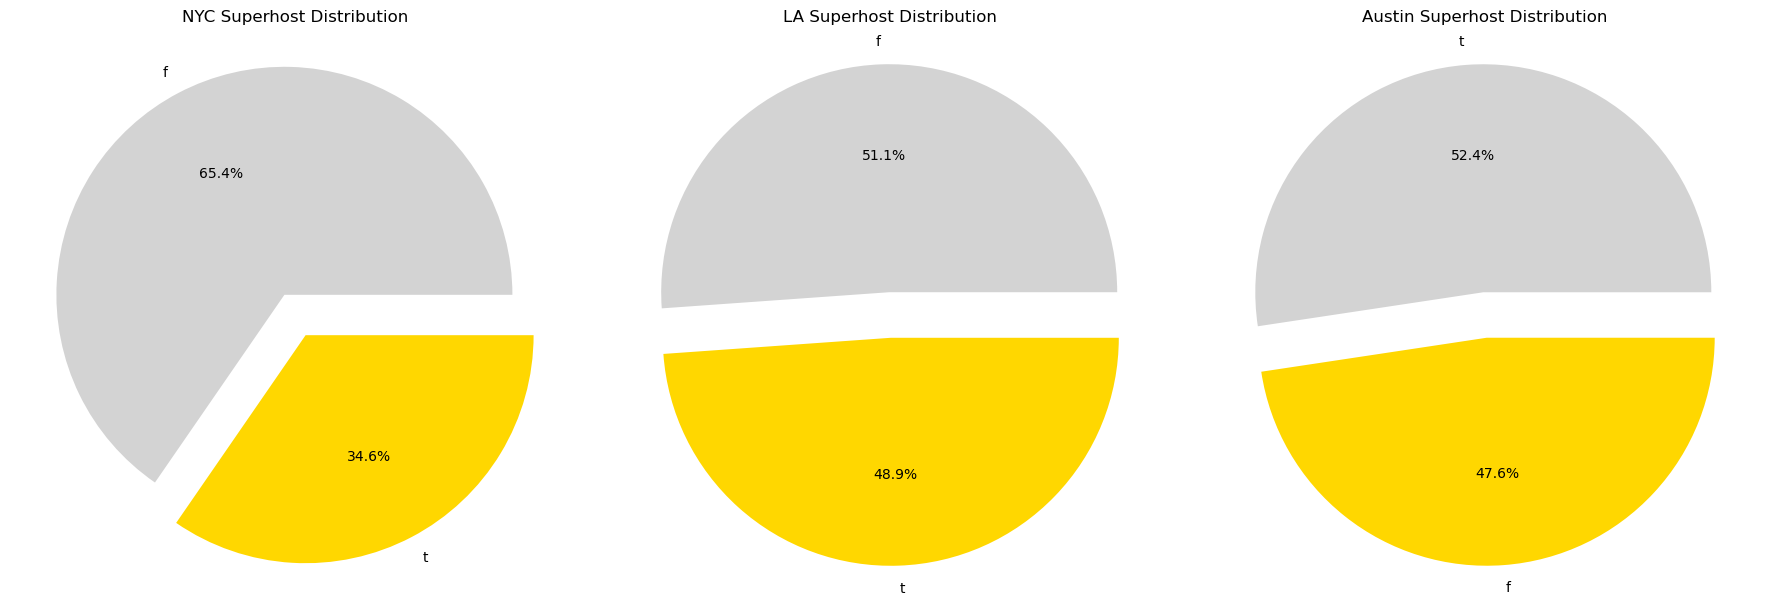

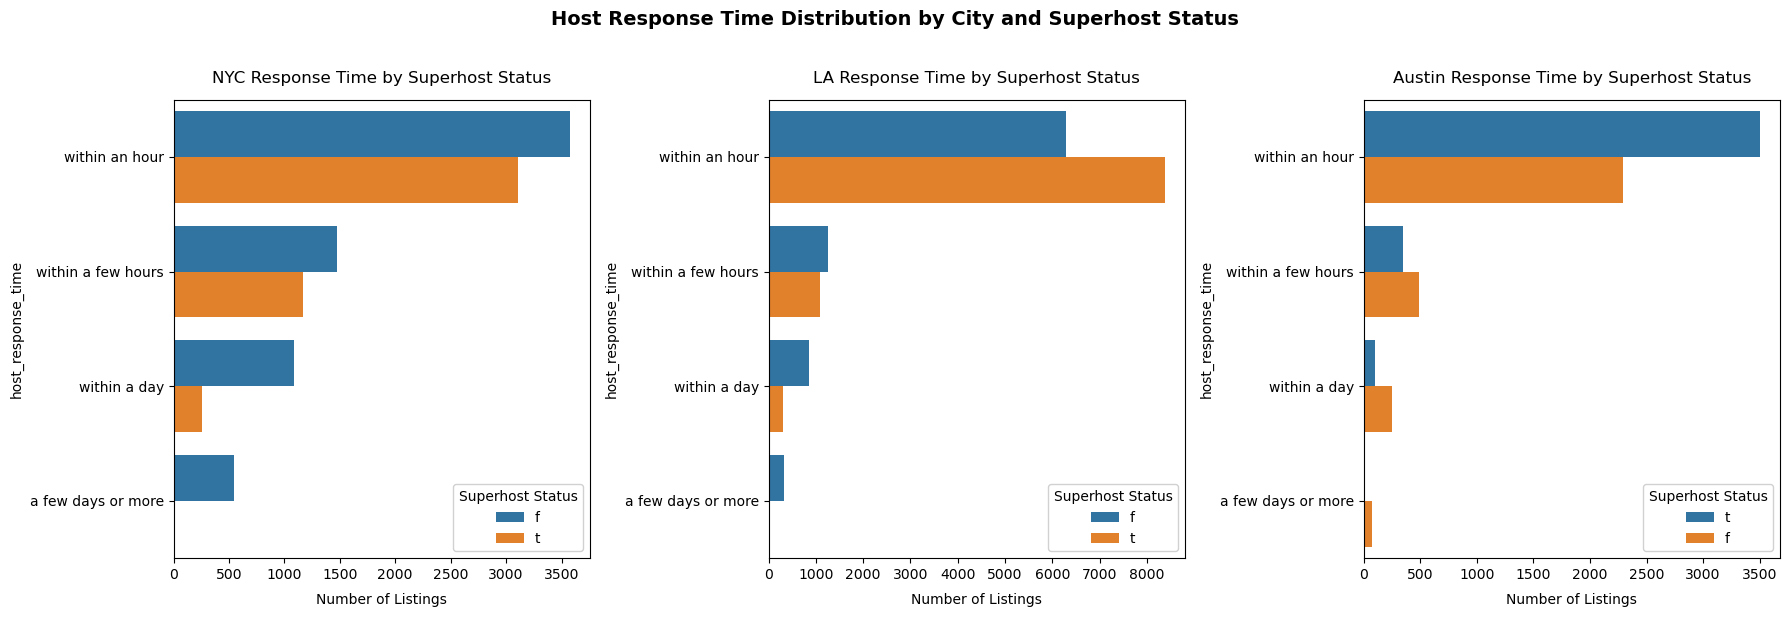

In [4]:
#Visualizing the distribution of superhost across each city
plt.figure(figsize=(18, 6))

# Define cities and datasets
cities = ['NYC', 'LA', 'Austin']
datasets = [nyc, la, aus]

# Create pie charts for each city
for i, (city, data) in enumerate(zip(cities, datasets), 1):
    plt.subplot(1, 3, i)
    value_counts = data['host_is_superhost'].dropna().value_counts()
    explode = [0.1] * len(value_counts)  # Match length of unique values
    colors = ['lightgray', 'gold'][:len(value_counts)]
    
    value_counts.plot.pie(
        autopct='%1.1f%%',
        colors=colors,
        explode=explode
    )
    plt.ylabel('')
    plt.title(f'{city} Superhost Distribution')

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 6))

#visualizing at the distribution of the response time of each city for superhosts vs non-superhosts
# Define the order for response times
time_order = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']

for i, (city, data) in enumerate(zip(cities, datasets), 1):
    plt.subplot(1, 3, i)
    sns.countplot(
    y='host_response_time',
    hue='host_is_superhost',
    data=data,
    order=time_order)
    plt.legend(
        title='Superhost Status',
        loc='lower right',
        frameon=True,
        framealpha=0.9
    )
    plt.title(f'{city} Response Time by Superhost Status', pad=12)
    plt.xlabel('Number of Listings', labelpad=8)

plt.suptitle('Host Response Time Distribution by City and Superhost Status',
             y=1.02, fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Compared to NYC and LA, Austin’s pie chart shows that around 40% of its hosts are Superhosts, which is significantly higher than the 18% in NYC and 21% in LA. This suggests that Austin’s hosting community may place a strong emphasis on maintaining high ratings, quick response times, and excellent guest experiences—factors that contribute to Superhost status.

### Analysis of Target Occupance Rate

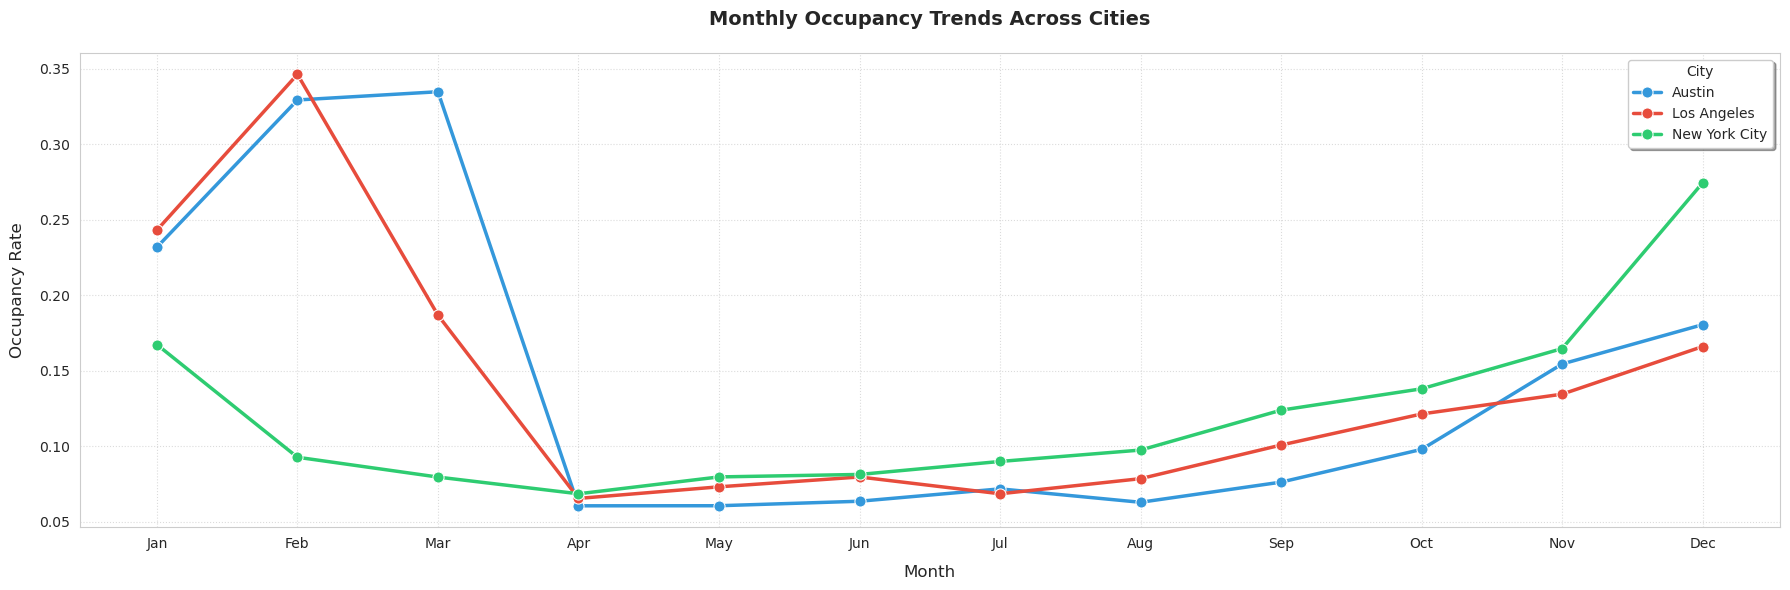

In [5]:
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
 
# Preparing data
def prepare_data(df):
    df['month'] = pd.to_datetime(df['last_review'], errors='coerce').dt.month
    return df
 
nyc = prepare_data(nyc.copy())
la = prepare_data(la.copy())
aus = prepare_data(aus.copy())
all_listings = pd.concat([nyc, la, aus]).reset_index(drop=True)
 
monthly_occupancy = all_listings.groupby(['City', 'month'])['Occupancy_Rate'].mean().reset_index()
 
# Create the plot
fig, ax1 = plt.subplots(figsize=(18, 6))
sns.lineplot(
    x='month',
    y='Occupancy_Rate',
    hue='City',
    data=monthly_occupancy,
    palette=['#3498db', '#e74c3c', '#2ecc71'],
    marker='o',
    markersize=8,
    linewidth=2.5,
    ax=ax1
)
ax1.set_title('Monthly Occupancy Trends Across Cities', pad=20, fontweight='bold')
ax1.set_xlabel('Month', labelpad=10)
ax1.set_ylabel('Occupancy Rate', labelpad=10)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax1.grid(True, linestyle=':', alpha=0.7)
ax1.legend(title='City', frameon=True, shadow=True)
 
plt.tight_layout()
plt.show()

- Both Los Angeles and New York City appear to experience higher occupancy in January and February, then see a dip in the spring months. This pattern suggests a possible seasonal boost during the winter period (e.g., holidays, New Year travel).
 
- The drop from late winter into spring, followed by gradual increases later in the year, underscores that seasonality is a critical component of occupancy trends. Hosts and investors may want to adjust pricing or marketing strategies around these seasonal patterns.

## Methods

To begin our modeling process, we split the data into three sets: training, validation, and testing. The training set is used to fit our models and build preprocessing steps. The validation set helps us evaluate model performance during development and tune parameters to avoid overfitting. The test set is used only to assess the final model’s performance. Our target variable is occupancy_rate, which represents how often a listing is booked throughout 2024.

To prepare the data for modeling, we created a preprocessing pipeline to handle both numeric and categorical variables. For numeric columns, we filled missing values using a Simple Imputer with the mean strategy and then applied standard scaling. For categorical variables, we imputed missing values with the most frequent category and used one-hot encoding to convert them into a numeric format suitable for machine learning. We applied these transformations using a ColumnTransformer so that both types of features were handled appropriately and in a reproducible way. The pipeline was fitted on the training set and then applied to the validation and test sets to ensure consistency.

We started modeling with a basic linear regression model to establish a baseline. This gave us a reference point for performance and allowed us to test whether simple relationships in the data could explain occupancy. As expected, the linear model performed reasonably on the training set, but struggled to generalize to the validation set. The drop in R² and increase in RMSE suggested the model was underfitting and that more complex methods might be needed to capture non-linear trends in the data.

To improve performance, we experimented with a variety of advanced models. These included tree-based models like Random Forest, XGBoost, and LightGBM, which are well-suited for handling non-linear interactions. We also tested a linear support vector regressor (SVR) for comparison. Finally, we trained a deep neural network using TensorFlow/Keras, which included multiple dense layers with ReLU activations, batch normalization, and dropout layers to improve generalization and training stability. The network ended with a sigmoid output to match our target range of 0 to 1. We used callbacks like early stopping and learning rate reduction to avoid overfitting and improve convergence.

After selecting our best-performing model, we developed a price optimization function. The goal was to identify the rate that maximizes yearly profit for a listing. This function takes a range of possible prices and, for each one, uses the model to predict the corresponding occupancy rate. We then compute the expected profit at each price and select the one with the highest return. This connects our machine learning predictions back to the core business objective of helping hosts and investors find the most profitable pricing strategy for their properties.

### Data Splitting: Train, Test, and Validation Sets

In [6]:
from sklearn.model_selection import train_test_split

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer

In [7]:
training = pd.read_csv("train_listings.csv")
testing = pd.read_csv("test_listings.csv")
val = pd.read_csv("val_listings.csv")

#split into x, y
train_x = training.drop(columns = ['Occupancy_Rate'])
train_y = training['Occupancy_Rate']

test_x = testing.drop(columns = ['Occupancy_Rate'])
test_y = testing['Occupancy_Rate']

val_x = val.drop(columns = ['Occupancy_Rate'])
val_y = val['Occupancy_Rate']

### Processing Pipeline

In this step we will split the numeric and categorical variables in order to create a separate pipeline for each variable type. 

- For numeric variables we will use a Simple Imputer with the mean strategy and apply a Standard Scaler.
- For categorical variables we will use Simple Imputer with the strategy being most frequent and an One Hot Encoder to transform our categorical variables (i.e. Neighborhood).

In [8]:
#creating variables sets, num and cat
num_vars = train_x.select_dtypes(include = ['float64','int64']).columns
cat_vars = train_x.select_dtypes(include = 'object').columns

#creating numeric_pipeline
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scalar', StandardScaler())])

#creating cat_pipeline
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy= 'most_frequent')),('encoder', OneHotEncoder(handle_unknown='ignore'))])

#creating preprocessor
preprocessing = ColumnTransformer([('num', num_pipeline, num_vars),('cat', cat_pipeline, cat_vars)])

#fitting and transforming the train to the preprocessing
train_x_process = preprocessing.fit_transform(train_x)

#transforming the validation data
val_x_process = preprocessing.transform(val_x)

#transforming the test data
test_x_process = preprocessing.transform(test_x)

### Baseline Linear Regression Model

For our baseline model we will be using a linear regression model as our y variable is a numeric that ranges from 0 to 0.70.

In [9]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#creating baseline model
linear_model_pipe = Pipeline([('linear_model', LinearRegression())])
linear_model_pipe.fit(train_x_process, train_y)

#predict for training
y_predict_train = linear_model_pipe.predict(train_x_process)

rmse_train = np.sqrt(mean_squared_error(train_y, y_predict_train))
r2_train = r2_score(train_y, y_predict_train)

#now with validation data
y_predict_val = linear_model_pipe.predict(val_x_process)

rmse_val = np.sqrt(mean_squared_error(val_y, y_predict_val))
r2_val = r2_score(val_y, y_predict_val)

### Neural Network

In this step we will build a neural network  where the architecture includes multiple dense layers with batch normalization and dropout to reduce overfitting. We also define a custom R² metric and set up model checkpointing to save the best-performing version during training.

In [ ]:
%%capture
#%pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import random
import os

#setting seeds
os.environ["PYTHONHASHSEED"] = "11"
random.seed(11)
np.random.seed(11)
tf.random.set_seed(11)

def r2_score(y_true, y_pred):
    #residual sum of squares
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    #total sum of squares
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    #R² value
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

checkpoint = ModelCheckpoint(
    filepath="best_model.h5",
    monitor='val_r2_score', 
    mode='max',              
    save_best_only=True,
    verbose=0
)


neural_network = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(train_x_process.shape[1],)),

    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(32),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(16),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(8),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

neural_network.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', r2_score])

history = neural_network.fit(train_x_process, train_y, epochs=150, validation_data = (val_x_process, val_y), callbacks=[checkpoint], verbose = 0)

## Results

This section summarizes the performance of our final occupancy rate prediction model. Model results for the tree-based and support vector machine methods discussed in the Methods section can be found in the **Model_Attempts** support notebook.

We evaluated our final model, a deep neural network, using _RMSE_ (Root Mean Squared Error), _MAE_ (Mean Absolute Error), and _R²_ (coefficient of determination) on the test dataset. These metrics reflect how well the model predicts the occupancy rate, which ranges from 0 to 0.7. The neural network achieved a test _MAE_ of **0.1024**, meaning that, on average, the occupancy rate predictions deviated by 10.24 percentage points from the actual values. The test _RMSE_ was **0.1334**, and _R²_ was **0.4645**, indicating moderate explanatory power. These results showed a slight improvement over our baseline linear regression model (which had a test _R²_ around **0.36**), suggesting the deep model generalizes better to unseen data.

Residual plots for the training, validation, and test sets were generated to visually assess prediction errors across the data range. While the patterns suggest decent performance overall, residuals were not uniformly distributed, especially for listings with lower predicted occupancy. This may indicate some non-linear relationships or noise not well captured by the model.

Finally, we applied the model to a pricing optimization task. By varying the price of a given listing and predicting the resulting occupancy rate, we estimated total profit for each price point. The model was able to identify an optimal price that significantly improved expected profits over the original listing price. This demonstrates how the model’s predictions can inform actionable strategies for hosts aiming to maximize revenue.


### Baseline Linear Regression Results

From the results, we can see that that model preformed very well when looking at the training data with a high R² and low RMSE, however when we try it with the validation data, the model's performance plummets with a drastically decreased R² and a 10x increase RMSE.

In [14]:
print(f"Training RMSE: {rmse_train:.4f}")
print(f"Training R² Score: {r2_train:.4f}")
print(f"Validation RMSE: {rmse_val:.4f}")
print(f"Validation R² Score: {r2_val:.4f}")

Training RMSE: 0.1464
Training R² Score: 0.3784
Validation RMSE: 0.1491
Validation R² Score: 0.3623


#### Residuals

Plotting the residuals of both the training and validation data.

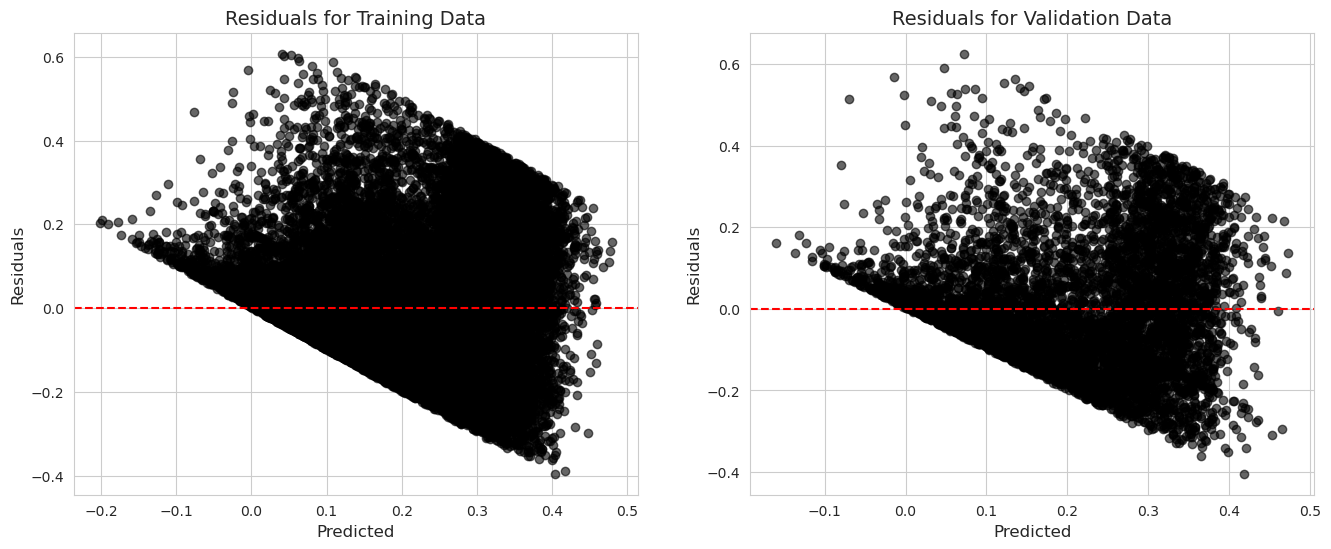

In [15]:
fig,axes = plt.subplots(1,2,figsize=(16,6))
#getting the residuals
residuals_train = train_y - y_predict_train
residuals_val = val_y - y_predict_val

#training residuals plot
axes[0].scatter(y_predict_train, residuals_train, color="black", alpha=0.6)
axes[0].axhline(y=0, color="red", linestyle="--")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals for Training Data")

#validation residuals plot
axes[1].scatter(y_predict_val, residuals_val, color="black", alpha=0.6)
axes[1].axhline(y=0, color="red", linestyle="--")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residuals for Validation Data")

plt.show()

From the side by side residual plots, we can see a large blob pattern on the lower predicted values for both the training and validation data. In the training residuals we can see a flat line across y = 0 just next to it's blobs which seems odd and needs further investigation.

### Neural Network Results

In [16]:
from tensorflow.keras.models import load_model
best_neural = load_model("best_model.h5", custom_objects={'r2_score': r2_score})

test_loss, test_mae, test_r2 = best_neural.evaluate(test_x_process, test_y)
print('\nTest MAE: ', round(test_mae,4))
print('\nTest R²: ', round(test_r2,4))
print('\nTest RMSE: ', round(np.sqrt(test_loss),4))

270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0184 - mean_absolute_error: 0.1040 - r2_score: 0.4562

Test MAE:  0.104

Test R²:  0.4522

Test RMSE:  0.1354


From the neural network results we can see marginial improvements in R² and RMSE, indicative that our Neural Network performed better than the baseline linear regression, though not by much.

#### Epoch History

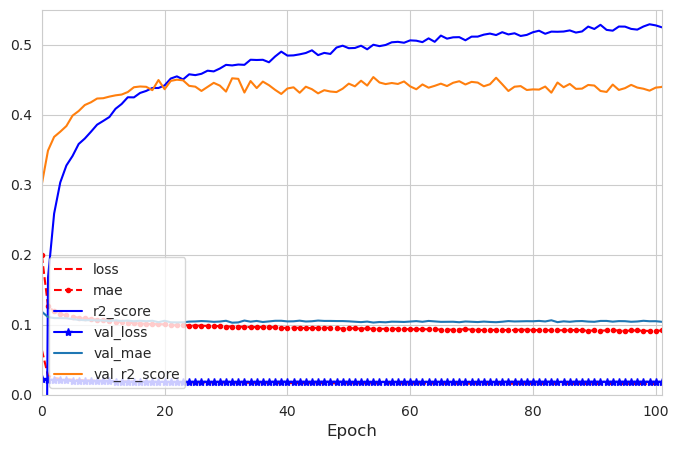

In [17]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 101], ylim=[0, 0.55], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")
plt.show()

The epoch history plot shows that the training and validation R² scores steadily improve and stabilize as the model trains, with the validation curve slightly below the training curve, indicating good generalization. The loss and MAE curves also flatten over time, suggesting convergence and no signs of overfitting.

#### Training/Validation/Testing Residual Plots

862/862 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


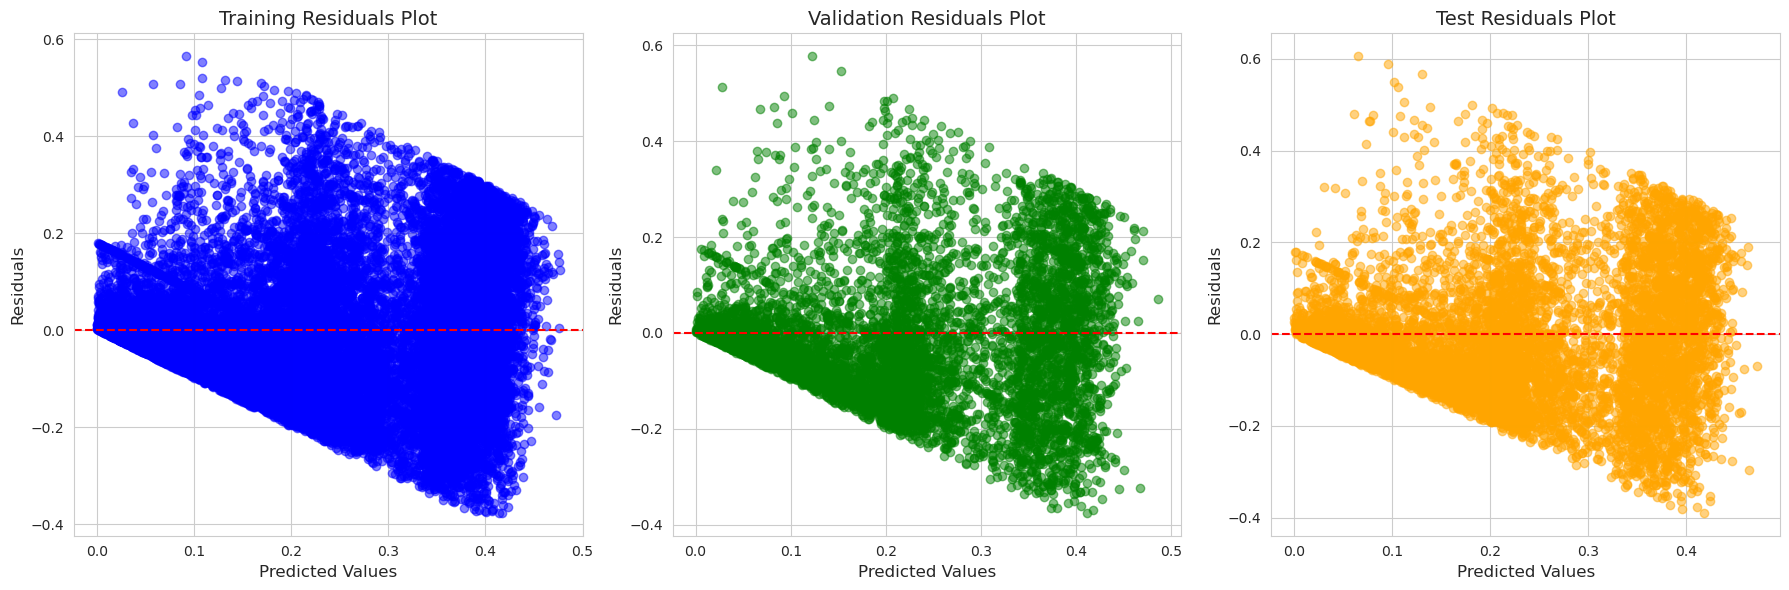

In [18]:
train_pred = best_neural.predict(train_x_process)
val_pred = best_neural.predict(val_x_process)
test_pred = best_neural.predict(test_x_process)

train_pred = train_pred.flatten()
val_pred = val_pred.flatten()
test_pred = test_pred.flatten()

#Calculate residuals for training, validation, and test sets
train_residuals = train_y - train_pred
val_residuals = val_y - val_pred
test_residuals = test_y - test_pred

#Create a subplot with 3 columns for training, validation, and test residuals
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# 5. Plot residuals for the training set
axs[0].scatter(train_pred, train_residuals, alpha=0.5, color='blue')
axs[0].axhline(y=0, color='red', linestyle='--')
axs[0].set_title('Training Residuals Plot')
axs[0].set_xlabel('Predicted Values')
axs[0].set_ylabel('Residuals')

# 6. Plot residuals for the validation set
axs[1].scatter(val_pred, val_residuals, alpha=0.5, color='green')
axs[1].axhline(y=0, color='red', linestyle='--')
axs[1].set_title('Validation Residuals Plot')
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Residuals')

# 7. Plot residuals for the test set
axs[2].scatter(test_pred, test_residuals, alpha=0.5, color='orange')
axs[2].axhline(y=0, color='red', linestyle='--')
axs[2].set_title('Test Residuals Plot')
axs[2].set_xlabel('Predicted Values')
axs[2].set_ylabel('Residuals')

# 8. Adjust layout for better spacing between subplots
plt.tight_layout()

# 9. Show the plots
plt.show()

The residual plots show a consistent pattern where residuals are more dispersed at lower predicted values, indicating uneven variance across predictions. All three plots share a downward triangular shape, suggesting the model tends to slightly underestimate higher values and overestimate lower ones, which may point to limitations in model flexibility or data distribution. While the overall spread is relatively centered around zero, the asymmetry suggests further tuning or feature engineering could improve predictive accuracy.

#### Price Optimization Curve

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Price: $77.00 → Predicted occupancy: 0.4024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Price: $87.00 → Predicted occupancy: 0.3994
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Price: $97.00 → Predicted occupancy: 0.3968
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Price: $107.00 → Predicted occupancy: 0.3927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Price: $117.00 → Predicted occupancy: 0.3897
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Price: $127.00 → Predicted occupancy: 0.3873
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Price: $137.00 → Predicted occupancy: 0.3843
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Price: $147.00 → Predicted occupancy: 0.3804
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Price: $157.00 → Predicted occupancy: 0.3755
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Price: $167.00 → Predicted occupancy: 0.3704
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Price: $177.00 → Predicted occupancy: 0.3658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Price: $187.00 → Predicted occupancy: 0.3616
1/1 ━━

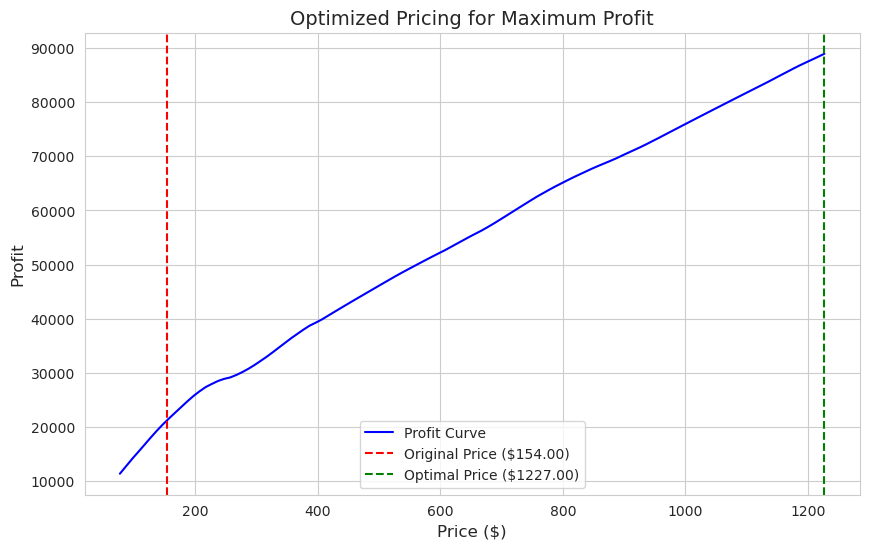

Optimal price: $1227.00, Max profit: $88983.37


In [19]:
def price_curve_nn(row):
    prices = []
    profits = []

    # Start from the actual price
    price = np.exp(row['log_price'].values[0])
    price_range = np.arange(price * 0.5, price * 8, 10)

    for p in price_range:
        copy_row = row.copy()
        copy_row['log_price'] = np.log(p)

        # Preprocess the row
        processed_input = preprocessing.transform(copy_row)
        
        # Predict occupancy using the neural network
        pred_occupancy = neural_network.predict(processed_input)[0][0]
        print(f"Price: ${p:.2f} → Predicted occupancy: {pred_occupancy:.4f}")

        profit = 365 * p * pred_occupancy
        prices.append(p)
        profits.append(profit)

    optimal_price = prices[np.argmax(profits)]

    plt.figure(figsize=(10, 6))
    plt.plot(prices, profits, label="Profit Curve", color='blue')
    plt.axvline(price, color='red', linestyle='--', label=f"Original Price (${price:.2f})")
    plt.axvline(optimal_price, color='green', linestyle='--', label=f"Optimal Price (${optimal_price:.2f})")
    plt.title("Optimized Pricing for Maximum Profit")
    plt.xlabel("Price ($)")
    plt.ylabel("Profit")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Optimal price: ${optimal_price:.2f}, Max profit: ${max(profits):.2f}")

price_curve_nn(test_x.iloc[[2]])

## Discussion

From our Neural Network, we were able to build a model that performs reasonably well at predicting the occupancy rate of Airbnb listings. However, when using this model to estimate the optimal listing price to maximize profit, it becomes clear that the model currently falls short. With many features being used to predict occupancy, the influence of the log_price variable appears too weak. This is evident in the profit curve example above, where the predicted occupancy rate decreases too slowly as price increases. As a result, the profit curve continues to rise for too long before eventually dropping, leading to unrealistically high recommended prices. In essence, this means we have not yet fully achieved the main goal of our stakeholders: identifying the ideal price point to maximize their annual profit.

While the Neural Network’s predictive performance was solid, there is room for improvement. Other models explored in the **Model_Attempts** notebook (Random Forest, LightGBM, and XGBoost), outperformed the Neural Network in terms of predicting occupancy rate. However, they were less effective when applied to profit optimization, which is why they were not chosen as the final model.

## Limitations

Overall, our final results were lack luster at best. During our exploration, we realized that our initial method for calculating occupancy rate was flawed, as it showed most listings having near-zero occupancy. After many trials, we arrived at a version that better aligned with external sources’ calculation of Occupancy Rate. However, this version still has limitationsv as it assumes that every guest who stays at an Airbnb leaves a review. From personal experience, we know that is not always the case, which means the occupancy values we used are likely underestimated.

Another major limitation was the amount of missing data. It is difficult to fully understand how much this impacted our model’s performance. We used simple imputation techniques to fill in the gaps, but more advanced methods might have yielded better results. Ultimately, the ideal solution would be to have a cleaner dataset with fewer missing or inconsistent entries, as that would likely lead to more robust and trustworthy model outcomes.

## Future Work

The next steps for our work are quite clear. As outlined above, the main issue limiting our model's performance was the lack of accurate Occupancy Rate data for each listing over the selected time period. Therefore, our first priority would be to acquire the real Occupancy Rates directly from Airbnb. With more accurate data, we would then reevaluate the models we’ve already built to see if their performance improves solely from the data enhancement.

From there, we would explore additional regression-based models such as Linear SVM and Generalized Additive Models (GAM), while also spending more time analyzing and incorporating potential interactions between features that influence occupancy. Another promising direction would be to segment the dataset—creating separate models for each state, region, or city. These more localized models might better capture regional trends and lead to improved predictions and more accurate optimal pricing for maximizing profit.